In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.sparse as sp

import pandas as pd

from itertools import combinations, permutations, product

In [2]:
fsize = 7
tsize = 9
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

In [4]:
def blockade_ladder(L):
    if L == 1:
        return [[0,0], [0,1], [1,0]]
    
    subreps = blockade_ladder(L-1)

    greps = [[0,0] + r for r in subreps]
    ureps = [[0,1] + r for r in subreps if r[1] != 1]
    dreps = [[1,0] + r for r in subreps if r[0] != 1]

    reps = greps + ureps + dreps

    return reps

def matrix_blockade_ladder(L):

    if L == 1:
        return [[0,0], [0,1], [1,0]]

    subreps = blockade_ladder(L-1)

    greps = [[0,0] + r for r in subreps]
    ureps = [[0,1] + r for r in subreps if r[1] != 1 and r[-1] != 1]
    dreps = [[1,0] + r for r in subreps if r[0] != 1 and r[-2] != 1]

    reps = greps + ureps + dreps

    #horizontal_reps = [np.hstack(np.transpose(np.reshape(i, (L,2)))) for i in vertical_reps] # type: ignore
    matrix_reps = np.array([np.transpose(np.reshape(i, (L,2))) for i in reps]) # type: ignore

    return matrix_reps

def open_matrix_blockade_ladder(L):

    if L == 1:
        return [[0,0], [0,1], [1,0]]

    subreps = blockade_ladder(L-1)

    greps = [[0,0] + r for r in subreps]
    ureps = [[0,1] + r for r in subreps if r[1] != 1]
    dreps = [[1,0] + r for r in subreps if r[0] != 1]

    reps = greps + ureps + dreps

    #horizontal_reps = [np.hstack(np.transpose(np.reshape(i, (L,2)))) for i in vertical_reps] # type: ignore
    matrix_reps = np.array([np.transpose(np.reshape(i, (L,2))) for i in reps]) # type: ignore

    return matrix_reps

def full_ladder(L):
    if L == 1:
        return [[0,0], [0,1], [1,0], [1,1]]
    
    subreps = full_ladder(L-1)

    greps = [[0,0] + r for r in subreps]
    ureps = [[0,1] + r for r in subreps]
    dreps = [[1,0] + r for r in subreps]
    breps = [[1,1] + r for r in subreps]

    reps = greps + ureps + dreps + breps

    return reps

def matrix_full_ladder(L):
    subreps = full_ladder(L)

    #horizontal_reps = [np.hstack(np.transpose(np.reshape(i, (L,2)))) for i in vertical_reps] # type: ignore
    matrix_reps = np.array([np.transpose(np.reshape(i, (L,2))) for i in subreps]) # type: ignore

    return matrix_reps

In [5]:
def blockade_line(L):
    if L == 1:
        return [[0], [1]]
    
    subreps = blockade_line(L-1)

    greps = [[0] + r for r in subreps]
    ereps = [[1] + r for r in subreps if r[0] != 1]

    reps = greps + ereps

    return reps

def matrix_blockade_line(L):

    if L == 1:
        return [[0], [1]]

    subreps = blockade_line(L-1)

    greps = [[0] + r for r in subreps]
    ereps = [[1] + r for r in subreps if r[0] != 1 and r[-1] != 1]

    reps = greps + ereps

    matrix_reps = np.array([np.transpose(np.reshape(i, (L,1))) for i in reps]) # type: ignore

    return matrix_reps

def open_matrix_blockade_line(L):

    if L == 1:
        return [[0], [1]]

    subreps = blockade_line(L-1)

    greps = [[0] + r for r in subreps]
    ereps = [[1] + r for r in subreps if r[0] != 1]

    reps = greps + ereps

    matrix_reps = np.array([np.transpose(np.reshape(i, (L,1))) for i in reps]) # type: ignore

    return matrix_reps

def full_line(L):
    if L == 1:
        return [[0], [1]]
    
    subreps = full_line(L-1)

    greps = [[0] + r for r in subreps]
    ereps = [[1] + r for r in subreps]

    reps = greps + ereps

    return reps

def matrix_full_line(L):

    if L == 1:
        return [[0], [1]]

    subreps = full_line(L-1)

    greps = [[0] + r for r in subreps]
    ereps = [[1] + r for r in subreps]

    reps = greps + ereps

    matrix_reps = np.array([np.transpose(np.reshape(i, (L,1))) for i in reps]) # type: ignore

    return matrix_reps


In [6]:
def sort(basis):
    sorted_basis = np.array(sorted(basis, key = lambda x: np.sum(x)))
    n_e_max = np.flip(basis)[0].sum()
    n_e, bin_edges = np.histogram([(x.sum(axis=0)).sum(axis=0) for x in sorted_basis], bins=n_e_max+1)
    edges = np.cumsum(n_e)#[:-1]
    return sorted_basis, edges

def split(sorted_basis, edges):
    split_basis = np.split(sorted_basis, edges)
    return split_basis

$$
H_n=\sum_i \hat{n}_i
$$

In [7]:
def number_hamiltonian(basis):

    sorted_basis, edges = sort(basis)
    dim = len(sorted_basis)

    diag = [np.sum(i) for i in sorted_basis] # 2L sites in 2 leg ladder

    mat = sp.dia_array((diag,0), shape=(dim, dim))

    return mat

$$
    H_\lambda = \sum_i \sigma_i^z
$$

In [8]:
def detuning_hamiltonian(basis):

    sorted_basis, edges = sort(basis)
    dim = len(sorted_basis)
    L = len(sorted_basis[0][0])
    N = L * len(sorted_basis[0])

    diag = [2*np.sum(i) - N for i in sorted_basis] # 2L sites in 2 leg ladder

    mat = sp.dia_array((diag,0), shape=(dim, dim))

    return mat

$$ H_\Delta = \sum_i (-1)^i \sigma_i^z

In [9]:
def staggered_detuning_hamiltonian(basis):

    sorted_basis, edges = sort(basis)
    dim = len(sorted_basis)

    diag0 = np.array([2*np.sum(i[0][::2]) - len(i[0][::2]) - (2*np.sum(i[0][1::2]) - len(i[0][1::2])) for i in sorted_basis]) # even - odd
    if len(sorted_basis[0]) == 2:
        diag1 = np.array([2*np.sum(i[1][::2]) - len(i[1][::2]) - (2*np.sum(i[1][1::2]) - len(i[1][1::2])) for i in sorted_basis]) # even - odd
    else:
        diag1 = np.zeros(dim)
    mat = sp.dia_array((diag0 + diag1,0), shape=(dim, dim))

    return mat

$$ H_\Omega = \sum_i \sigma_i^x

In [10]:
def rabi_hamiltonian(basis):

    sorted_basis, edges = sort(basis)
    split_basis = split(sorted_basis, edges)

    edges = np.append(0, edges[:-1])
    dim = len(sorted_basis)
    L = len(sorted_basis[0][0])
    legs = len(sorted_basis[0])

    empty = sp.coo_array((dim, dim))
    r_mat = np.full((legs, L), empty)

    for count, set in enumerate(split_basis):
        for x, state in enumerate(set):
            compare = state == split_basis[count+1]
            matches = np.sum(np.sum(compare, axis=1), axis=1)
            couplings = np.where(matches == legs*L-1)[0]

            for y in couplings:
                error = np.where(compare[y] == 0)
                r_mat[error[0][0], error[1][0]] += sp.coo_array(([1], ([edges[count] + x], [edges[count + 1] + y])), shape=(dim,dim))
                r_mat[error[0][0], error[1][0]] += sp.coo_array(([1], ([edges[count + 1] + y], [edges[count] + x])), shape=(dim,dim))

    mat = np.sum(r_mat)

    return mat, r_mat

$$H_t = \sum_{\langle ij\rangle} \left( b_i^\dagger b_j + \text{h.c.}\right)

In [11]:
def hopping_hamiltonian(basis, bc):

    sorted_basis, edges = sort(basis)
    split_basis = split(sorted_basis, edges)

    edges = np.append(0, edges[:-1])
    dim = len(sorted_basis)
    L = len(sorted_basis[0][0])
    
    if bc == 'PBC':
        l = len(sorted_basis[0][0])
    elif bc == 'OBC':
        l = 0

    legs = len(sorted_basis[0])

    empty = sp.coo_array((dim, dim))

    h_mat = np.full((legs,L), empty)
    v_mat = np.full((legs,L), empty)
    d_mat = np.full((legs,L), empty)

    for count, set in enumerate(split_basis):
        for x, state in enumerate(set):
            compare = state == set
            matches = np.sum(np.sum(compare, axis=1), axis=1)
            possible_couplings = np.where(matches == legs*L-2)[0]
            #print(compare)
            couplings = []

            for y in possible_couplings:
                errors = np.where(compare[y] == 0)
                diff = np.diff(errors)
                if np.all(diff == [[0],[1]]) or np.all(diff == [[0],[-(l-1)]]): # Horizontal
                    h_mat[errors[0][0]][errors[1][0]] += sp.coo_array(([1], ([edges[count] + x], [edges[count] + y])), shape=(dim,dim))

                elif np.all(diff == [[0],[0]]) or np.all(diff == [[0],[l-1]]): # Horizontal
                    h_mat[errors[0][1]][errors[1][1]] += sp.coo_array(([1], ([edges[count] + x], [edges[count] + y])), shape=(dim,dim))

                elif np.all(diff == [[1],[0]]): # Vertical
                    v_mat[errors[0][0]][errors[1][0]] += sp.coo_array(([1], ([edges[count] + x], [edges[count] + y])), shape=(dim,dim))

                elif np.all(diff == [[-1],[0]]): # Vertical
                    v_mat[errors[0][1]][errors[1][1]] += sp.coo_array(([1], ([edges[count] + x], [edges[count] + y])), shape=(dim,dim))

                elif np.all(diff == [[1],[-1]]) or np.all(diff == [[-1],[-1]]) or np.all(diff == [[1],[(l-1)]]) or np.all(diff == [[-1],[(l-1)]]): # Diagonal
                    d_mat[errors[0][1]][errors[1][1]] += sp.coo_array(([1/(2**1.5)], ([edges[count] + x], [edges[count] + y])), shape=(dim,dim))

                elif np.all(diff == [[1],[1]]) or np.all(diff == [[-1],[1]]) or np.all(diff == [[1],[-(l-1)]]) or np.all(diff == [[-1],[-(l-1)]]): # Diagonal
                    d_mat[errors[0][0]][errors[1][0]] += sp.coo_array(([1/(2**1.5)], ([edges[count] + x], [edges[count] + y])), shape=(dim,dim))

    mat = np.sum(h_mat) + np.sum(v_mat) + np.sum(d_mat)

    return mat, h_mat, v_mat, d_mat

In [12]:
def interaction_strength(state, L, bc):
    potential = []

    for combo in combinations(np.transpose(np.where(state)), 2):  # 2 for pairs, 3 for triplets, etc
        diff = np.linalg.norm(np.diff(np.reshape(combo, (2,2)).T))
        # if diff == 1 or (diff == L-1 and bc=='PBC'):
        #     potential.append(1)
        potential.append(1/diff**6)

    return np.sum(potential)

def interaction_hamiltonian(basis, bc):

    sorted_basis, edges = sort(basis)

    L = len(sorted_basis[0][0])

    dim = len(sorted_basis)

    diag = []

    for i in sorted_basis:
        diag.append(interaction_strength(i, L, bc))

    mat = sp.dia_array((diag,0), shape=(dim, dim))

    return mat

In [13]:
def groundstate(mat):

    num_states = 1
    E, GS = sp.linalg.eigsh(mat.mat, k=num_states, which='SA')

    while num_states < len(mat.basis) - 1:

        num_states += 1

        new_E, new_GS = sp.linalg.eigsh(mat.mat, k=num_states, which='SA')

        gaps = np.diff(new_E)
        max_gap = np.max(gaps)

        if max_gap > 1e-10:
            break

        # limit maximum gap
        # problem: lanczos can't fucking decide on the degeneracy

        E = new_E
        GS = new_GS

    return np.round(E, 10), np.sum(GS, axis=1)/np.sqrt(num_states - 1), num_states - 1

@np.vectorize
def GS(mat):

    num_states = 1
    E, GS = sp.linalg.eigsh(mat.mat, k=num_states, which='SA')

    while num_states < len(mat.basis) - 1:

        num_states += 1

        new_E, new_GS = sp.linalg.eigsh(mat.mat, k=num_states, which='SA')

        gaps = np.diff(new_E)
        max_gap = np.max(gaps)

        if max_gap > 1e-10:
            break

        # limit maximum gap
        # problem: lanczos can't fucking decide on the degeneracy

        E = new_E
        GS = new_GS

    return np.sum(GS, axis=1)/np.sqrt(num_states - 1)


In [14]:
lat = lattice(15, legs=1, bc='OBC', constraint=True)
mat = matrix(lat, det=0, stag=0, hop=1/2, rabi=1)

print(mat.gs.T @ lat.stag @ mat.gs)

fig = create_plot(lat, mat)

NameError: name 'lattice' is not defined

In [15]:
class lattice:
    def __init__(self, sites, bc='OBC', legs=1, constraint=True) -> None:
        self.sites = sites

        if legs == 1:
            if constraint == True:
                if bc == 'PBC':
                    self.basis = sort(matrix_blockade_line(self.sites))[0]
                elif bc == 'OBC':
                    self.basis = sort(open_matrix_blockade_line(self.sites))[0]
            else:
                self.basis = sort(matrix_full_line(self.sites))[0]
            
        elif legs == 2:
            if constraint == True:
                if bc == 'PBC':
                    self.basis = sort(matrix_blockade_ladder(self.sites))[0]
                elif bc == 'OBC':
                    self.basis = sort(open_matrix_blockade_ladder(self.sites))[0]
            else:
                self.basis = sort(matrix_full_ladder(self.sites))[0]

        
        self.num = number_hamiltonian(self.basis)
        self.det = detuning_hamiltonian(self.basis)
        self.stag = staggered_detuning_hamiltonian(self.basis)
        self.rabi, self.r_rabi = rabi_hamiltonian(self.basis)
        self.hop, self.h_hop, self.v_hop, self.d_hop = hopping_hamiltonian(self.basis, bc)
        self.int = interaction_hamiltonian(self.basis, bc)
    
class matrix(lattice):
    def __init__(self, lattice, num=0.0, det=0.0, stag=0.0, rabi=0.0, hop=0.0, int=0.0) -> None:
        self.sites = lattice.sites
        self.basis = lattice.basis

        self.det, self.stag, self.rabi, self.hop, self.int = det, stag, rabi, hop, int

        self.mat = num * lattice.num + det * lattice.det + stag * lattice.stag + rabi * lattice.rabi + hop * lattice.hop + int * lattice.int
        self.energy, self.gs, self.degen = groundstate(self)
        #self.dist = np.dot(self.cont.transpose(), np.reshape(self.basis, (len(self.basis), 2*self.sites))).transpose()
        #self.dens = np.sum(self.dist) / (2 * self.sites)
    # def gs(self):
    #     return np.vectorize(GS(self))


In [16]:
def create_plot(lat, mat):

    fig, ax = plt.subplots(nrows=2, ncols=2, sharex='none', sharey='none')

    X = range(lat.sites)

    ax[0,0].set_title('Excitation density')
    ax[0,0].plot([np.sum([mat.gs[k]**2 * mat.basis[k][0,x] for k in range(len(mat.basis))]) for x in X])
    #ax[0,0].plot([np.sum([mat.gs[k]**2 * mat.basis[k][1,x] for k in range(len(mat.basis))]) for x in X])
    ax[0,0].set_ylim([0,1])

    ax[0,1].set_title('Contribution')
    ax[0,1].bar(range(len(np.square(mat.gs))), np.square(mat.gs))

    ax[1,0].set_title(r'Rabi Term')
    ax[1,0].plot([mat.gs.T @ lat.r_rabi[0,x] @ mat.gs for x in X])
    #ax[1,0].plot([mat.gs.T @ lat.r_rabi[1,x] @ mat.gs for x in X])

    ax[1,1].set_title(r'Hopping Term')
    ax[1,1].plot([mat.gs.T @ lat.h_hop[0,x] @ mat.gs for x in X], label='Horizontal')
    #ax[1,1].plot([mat.gs.T @ lat.h_hop[1,x] @ mat.gs for x in X], label='Horizontal')
    ax[1,1].plot([mat.gs.T @ lat.v_hop[0,x] @ mat.gs for x in X], label='Vertical')
    ax[1,1].plot([mat.gs.T @ lat.d_hop[0,x] @ mat.gs for x in X], label='Diagonal')
    #ax[1,1].plot([mat.gs.T @ lat.d_hop[1,x] @ mat.gs for x in X], label='Diagonal')
    ax[1,1].legend()

    ax[1,0].set_xlabel('Site Index')
    ax[1,1].set_xlabel('Site Index')

    ax[0,0].set_ylabel('Expactation value')
    ax[1,0].set_ylabel('Expactation value')

    fig.suptitle(rf'$H = {mat.stag} + H_\Delta {mat.det} H_\lambda + {mat.rabi} H_\Omega + {mat.hop} H_t$', fontsize='16')
    fig.set_dpi(150)

    return fig

In [17]:
lat = lattice(15, legs=1, bc='OBC', constraint=True)

hop_values = [.5, 0, 1, 1]
rabi_values = [1, 1, 0, .5]

table_data = []

def get_O(lat, t, w):
    mat = matrix(lat, det=0, stag=0, hop=t, rabi=w)
    return mat.gs.T @ lat.stag @ mat.gs

def get_O2(lat, t, w):
    mat = matrix(lat, det=0, stag=0, hop=t, rabi=w)
    return mat.gs.T @ np.sqrt(lat.stag ** 2) @ mat.gs

for hop, rabi in zip(hop_values, rabi_values):
    result = get_O(lat, hop, rabi)
    table_data.append({'t': hop, r'$\Omega$': rabi, r'$\langle \hat{O} \rangle$': result})

df = pd.DataFrame(table_data)

print(df)

table_data = []

for hop, rabi in zip(hop_values, rabi_values):
    result = get_O2(lat, hop, rabi)
    table_data.append({'t': hop, r'$\Omega$': rabi, r'$\langle \hat{O} \rangle$': result})

df = pd.DataFrame(table_data)

print(df)

     t  $\Omega$  $\langle \hat{O} \rangle$
0  0.5       1.0                   7.000000
1  0.0       1.0                   0.800852
2  1.0       0.0                  -0.734626
3  1.0       0.5                   2.007709
     t  $\Omega$  $\langle \hat{O} \rangle$
0  0.5       1.0                   7.007812
1  0.0       1.0                   3.463118
2  1.0       0.0                   3.715989
3  1.0       0.5                   4.029241


In [31]:
lat = lattice(15)

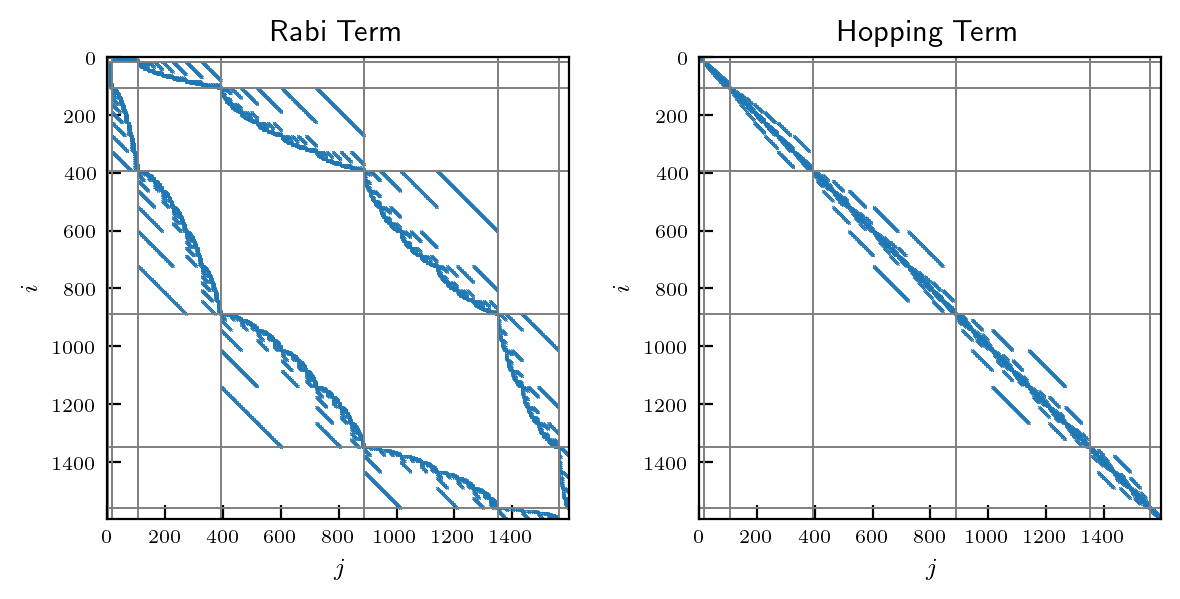

In [76]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3), dpi=200)

edges = sort(lat.basis)[1]

ax[0].spy(lat.rabi, markersize=.0001)
ax[0].set_title('Rabi Term', size=11)

ax[1].spy(lat.hop, markersize=.0001)
ax[1].set_title('Hopping Term', size=11)

for i in range(2):
    ax[i].hlines(edges, 0, np.shape(lat.rabi)[0], linewidth=.7, color='tab:gray')
    ax[i].vlines(edges, 0, np.shape(lat.rabi)[0], linewidth=.7, color='tab:gray')
    ax[i].set_xlabel(r'$j$', size=9)
    ax[i].set_ylabel(r'$i$', size=9)
    ax[i].tick_params(top=False, labeltop=False, labelbottom=True)

In [18]:
L = 21

lat = lattice(L, legs=1, bc='OBC', constraint=True)

A = np.array([1, 0])
B = np.array([1, -1]) / np.sqrt(2)

s = np.kron(np.kron(np.kron(A, B), A), B)

def ansatz1(L):
    if L == 1:
        return A
    ansatz = ansatz2(L-1)
    return np.kron(A, ansatz)

def ansatz2(L):
    if L == 1:
        return B
    ansatz = ansatz1(L-1)
    return np.kron(B, ansatz)

restricted = np.array([int(''.join(map(str, lat.basis[i][0])), 2) for i in range(len(lat.basis))])

Ansatz1 = ansatz1(L)[restricted]
Ansatz2 = ansatz2(L)[restricted]

#binary = np.array([[int(bit) for bit in f"{i:0{L}b}"] for i in range(len(s))])

#for i in range(len(s)):
#    print(s[i], ':', [int(bit) for bit in f"{i:0{L}b}"])

In [27]:
def ansatzmatch(L):
    lat = lattice(L, legs=1, bc='OBC', constraint=True)
    mat = matrix(lat, rabi=2, hop=1)
    
    A = np.array([1, 0])
    B = np.array([1, -1]) / np.sqrt(2)
    
    s = np.kron(np.kron(np.kron(A, B), A), B)
    
    def ansatz1(L):
        if L == 1:
            return A
        ansatz = ansatz2(L-1)
        return np.kron(A, ansatz)
    
    def ansatz2(L):
        if L == 1:
            return B
        ansatz = ansatz1(L-1)
        return np.kron(B, ansatz)
    
    restricted = np.array([int(''.join(map(str, lat.basis[i][0])), 2) for i in range(len(lat.basis))])
    
    #Ansatz1 = ansatz1(L)[restricted]
    Ansatz2 = ansatz2(L)[restricted]

    return np.abs(Ansatz2.T @ mat.gs)**2, np.abs(Ansatz2.T @ mat.gs)**2 - 1

#binary = np.array([[int(bit) for bit in f"{i:0{L}b}"] for i in range(len(s))])

#for i in range(len(s)):
#    print(s[i], ':', [int(bit) for bit in f"{i:0{L}b}"])

In [19]:
lat = lattice(21, legs=1, bc='OBC')
mat = matrix(lat, rabi=2, hop=1)

print(np.abs(Ansatz1.T @ mat.gs)**2)
print(np.abs(Ansatz2.T @ mat.gs)**2)
print(np.abs(Ansatz2.T @ mat.gs)**2 - 1)

4.768371582037521e-07
1.0
0.0


In [28]:
for i in range(3,21,2):
    print(ansatzmatch(i))
    

(0.9999999999999996, -4.440892098500626e-16)
(1.0, 0.0)
(0.9999999999999996, -4.440892098500626e-16)
(1.0000000000000018, 1.7763568394002505e-15)
(0.9999999999999989, -1.1102230246251565e-15)
(0.9999999999999982, -1.7763568394002505e-15)
(0.9999999999999982, -1.7763568394002505e-15)
(1.0, 0.0)
(0.9999999999999982, -1.7763568394002505e-15)


In [20]:
# lat = lattice(11, legs=1, bc='OBC', constraint=True)

# hop_values = [.5, 0, 1, 1]
# rabi_values = [1, 1, 0, .5]

# table_data = []

# for hop, rabi in zip(hop_values, rabi_values):
#     result1 = (Ansatz1.T @ matrix(lat, hop=hop, rabi=rabi).gs)**2
#     result2 = (Ansatz2.T @ matrix(lat, hop=hop, rabi=rabi).gs)**2
#     table_data.append({'t': hop, r'$\Omega$': rabi, r'$\psi_a^{(1)}$': result1, r'$\psi_a^{(2)}$': result2})

# df = pd.DataFrame(table_data)

# print(df)

Text(0.02, 0.5, 'Excitation density')

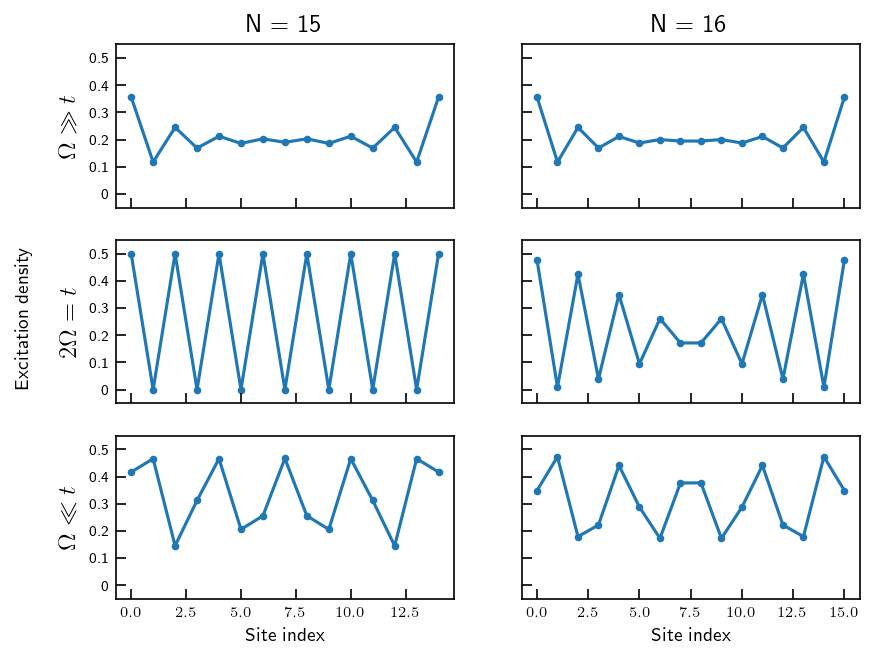

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex='col', sharey='all', dpi=150)

N1 = 15
N2 = 16

lat = [lattice(N1, legs=1, bc='OBC'), lattice(N2, legs=1, bc='OBC')]
rabi = [1, 2, 0]
hop = [0, 1, 1]

for i in range(2):
    for j in range(3):
        mat = matrix(lattice=lat[i], rabi=rabi[j], hop=hop[j])
        density = [np.sum([mat.gs[k]**2 * mat.basis[k][0,x] for k in range(len(mat.basis))]) for x in range(mat.sites)]
        ax[j,i].plot(density)
        ax[j,i].scatter(range(len(density)), density, s=7)

ax[0,0].set_title(f'N = {N1}', size=12)
ax[0,1].set_title(f'N = {N2}', size=12)

ax[0,0].set_ylabel(r'$\Omega \gg t$', size=12)
ax[1,0].set_ylabel(r'$2\Omega = t$', size=12)
ax[2,0].set_ylabel(r'$\Omega \ll t$', size=12)
ax[1,0].set_ylim(-0.05, .55)

ax[2,0].set_xlabel('Site index', size=9)
ax[2,1].set_xlabel('Site index', size=9)

ax[1,0].set_yticks([0,0.1,0.2,0.3,0.4,0.5], labels=[0,0.1,0.2,0.3,0.4,0.5])

#fig.suptitle('Test')
fig.supylabel('Excitation density', size=9)

TypeError: 'list' object is not callable

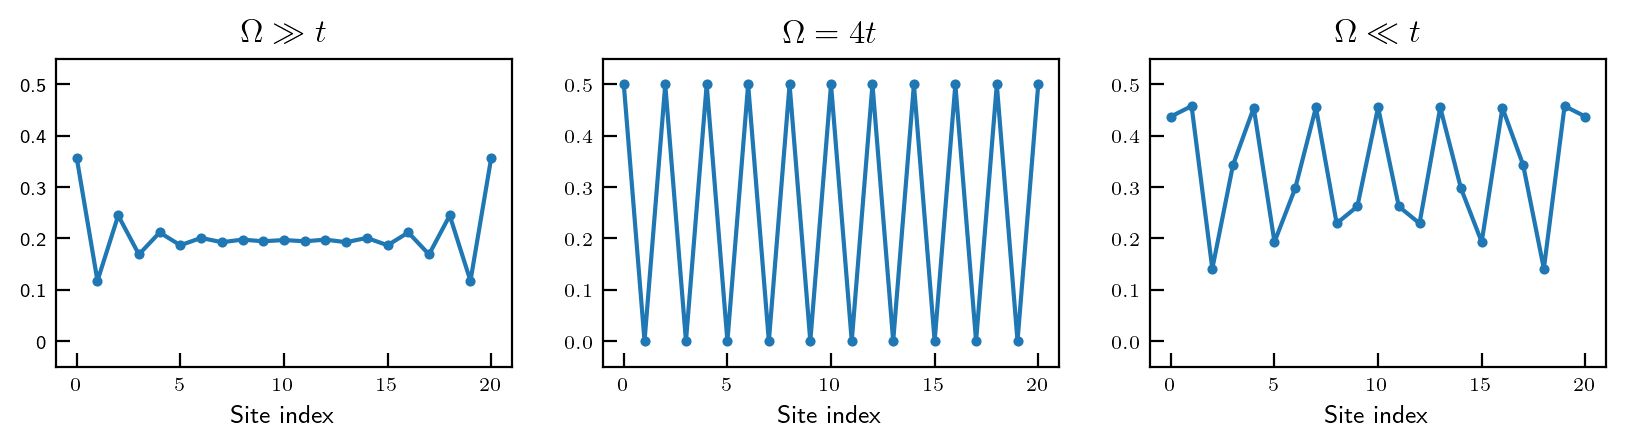

In [103]:
L = 21

lat = lattice(L, legs=1, bc='OBC', constraint=True)

fig, ax = plt.subplots(nrows=1, ncols=3, dpi=200, figsize=(10, 2))

rabi = [1, 2, 0]
hop = [0, 1, 1]

for j in range(3):
    mat = matrix(lattice=lat, rabi=rabi[j], hop=hop[j], int=0)
    density = [np.sum([mat.gs[k]**2 * mat.basis[k][0,x] for k in range(len(mat.basis))]) for x in range(mat.sites)]
    ax[j].plot(density)
    ax[j].scatter(range(len(density)), density, s=7)

ax[0].set_title(r'$\Omega \gg t$', size=12)
ax[1].set_title(r'$\Omega = 4t$', size=12)
ax[2].set_title(r'$\Omega \ll t$', size=12)
ax[0].set_ylim(-0.05, .55)
ax[1].set_ylim(-0.05, .55)
ax[2].set_ylim(-0.05, .55)

ax[0].set_xlabel('Site index', size=9)
ax[1].set_xlabel('Site index', size=9)
ax[2].set_xlabel('Site index', size=9)

ax[0].set_yticks([0,0.1,0.2,0.3,0.4,0.5], labels=[0,0.1,0.2,0.3,0.4,0.5])
ax[0].set_xticks(np.arange(0, L, int(np.round(L/5))), labels=np.arange(0, L, int(np.round(L/5))))
ax[1].set_xticks(np.arange(0, L, int(np.round(L/5))), labels=np.arange(0, L, int(np.round(L/5))))
ax[2].set_xticks(np.arange(0, L, int(np.round(L/5))), labels=np.arange(0, L, int(np.round(L/5))))

# fig.suptitle('Test')
ax[0].set_ylabel('Excitation density', size=9)

In [16]:
def GS(lat, X, Y):

    mat = X*lat.det + 1/2*lat.rabi+Y**6*lat.int

    num_states = 1
    E, GS = sp.linalg.eigsh(mat, k=num_states, which='SA')

    while num_states < len(lat.basis) - 1:

        num_states += 1

        new_E, new_GS = sp.linalg.eigsh(mat, k=num_states, which='SA')

        gaps = np.diff(new_E)
        max_gap = np.max(gaps)

        if max_gap > 1e-10:
            break

        # limit maximum gap
        # problem: lanczos can't fucking decide on the degeneracy

        E = new_E
        GS = new_GS

    return np.sum(GS, axis=1)/np.sqrt(num_states - 1)


In [81]:
def S_vn(GS,N,N_l,N_r):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams['font.size'] = '16'
    GS = GS.reshape((2 ** N, 1))

    n1, n2, n = 2 ** N_l, 2 ** N_r, 2 ** N
    rho = GS @ np.conj(GS.T)
    rho = rho / np.trace(rho)
    rho_tensor = rho.reshape([n1, n2, n1, n2])
    # np.trace(rho_tensor, axis1=1, axis2=3)  # rho_a
    rho_a = np.trace(rho_tensor, axis1=0, axis2=2)
    # print(rho_a.shape)
    pn = np.real(np.linalg.eigvalsh(rho_a))
    n = pn > 0
    if len(n) > 0:
        # print("IF")
        S = -np.sum(pn[n] * np.log(pn[n]))
    else:
        # print("Else")
        S = 0.0  # p log p = 0 if p = 0

    if S == 0:
        S = abs(S)

    return np.round(S,4)

In [25]:
print(lat.int.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.12830903 0.         0.        ]
 [0.         0.         0.         ... 0.         0.14275793 0.        ]
 [0.         0.         0.         ... 0.         0.         0.1586539 ]]


In [87]:
L = 13

lat = lattice(L, legs=1, bc='OBC', constraint=False)

X, Y = np.meshgrid(
    np.linspace(1,5,40),
    np.linspace(1,5,40) # y_max = 4 ?
)

print(X.shape)

Z = np.zeros_like(X)
for x in range(X.shape[0]):
    print(x)
    for y in range(Y.shape[1]):
        print(y)
        try:
            # print(X[0,x], Y[y,0])
            mat = matrix(lat, num=-X[0,x], rabi=.5, int=Y[y,0]**6)
            # z = np.sum(mat.basis[:,0,:].T * mat.gs**2)
            z = S_vn(mat.gs, L,L//2+L%2,L//2)
        except:
            pass
        else:
            Z[x,y] = z


(40, 40)
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
3

In [91]:
np.save('phase55.npy', Z)

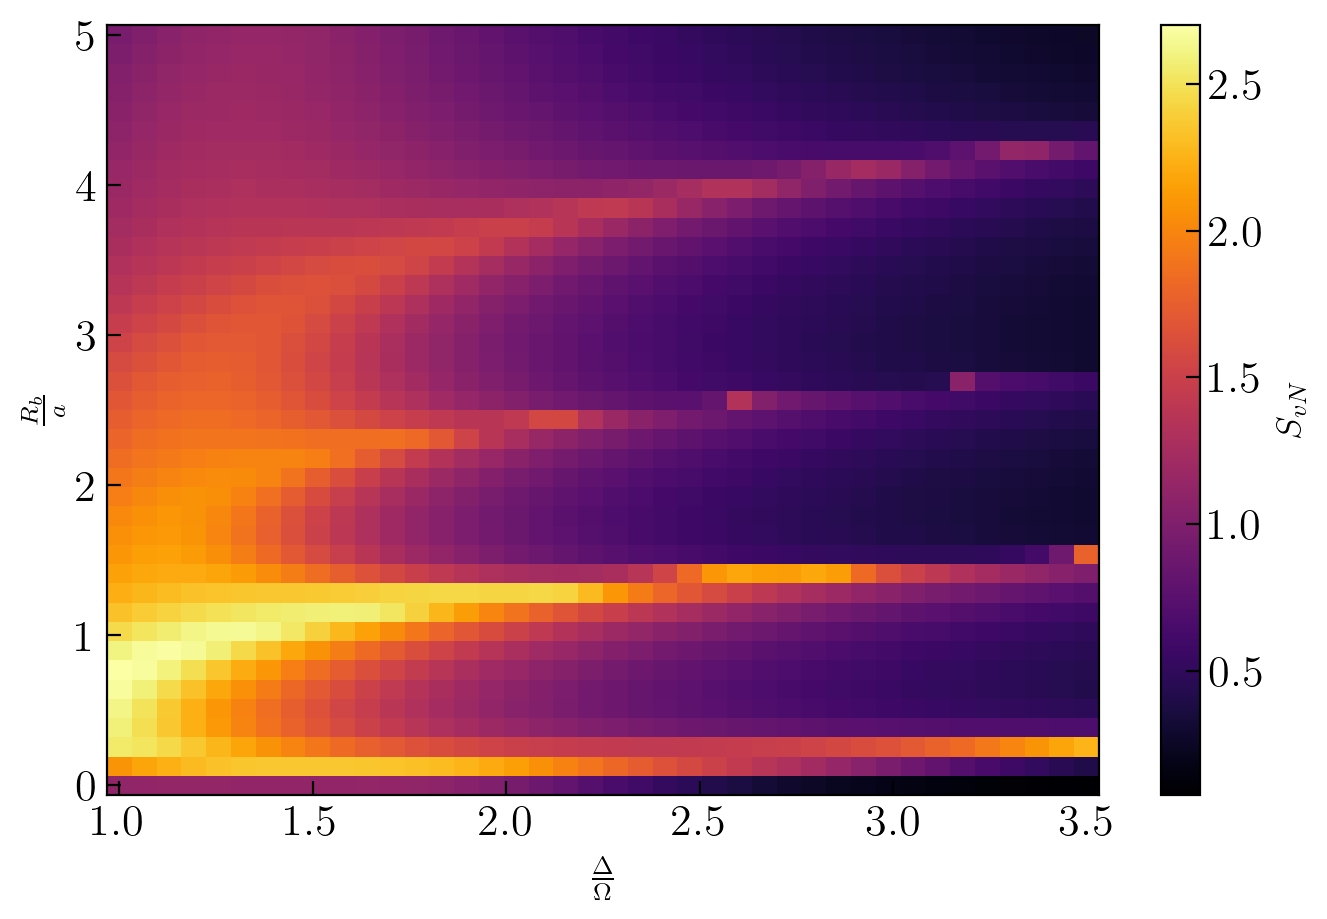

In [93]:
fig, ax = plt.subplots(figsize=(8,5), dpi=200)

c = ax.pcolormesh(X, Y, Z.T, cmap='inferno')
ax.set_xlabel(r'$\frac{\Delta}{\Omega}$', size=13)
ax.set_ylabel(r'$\frac{R_b}{a}$', size=13)

# ax.scatter([3, 3, 3, 3],[0.5, 1.5, 2.5, 3.5], c='white', s=1)
# ax.text(3+.05, 0.5-.1, r'$Z_1$', c='white', size=13)
# ax.text(3+.05, 1.5-.1, r'$Z_2$', c='white', size=13)
# ax.text(3+.05, 2.5-.1, r'$Z_3$', c='white', size=13)
# ax.text(3+.05, 3.5-.1, r'$Z_4$', c='white', size=13)

cb = fig.colorbar(c, ax=ax)
cb.set_label(r'$S_{vN}$', size=13)

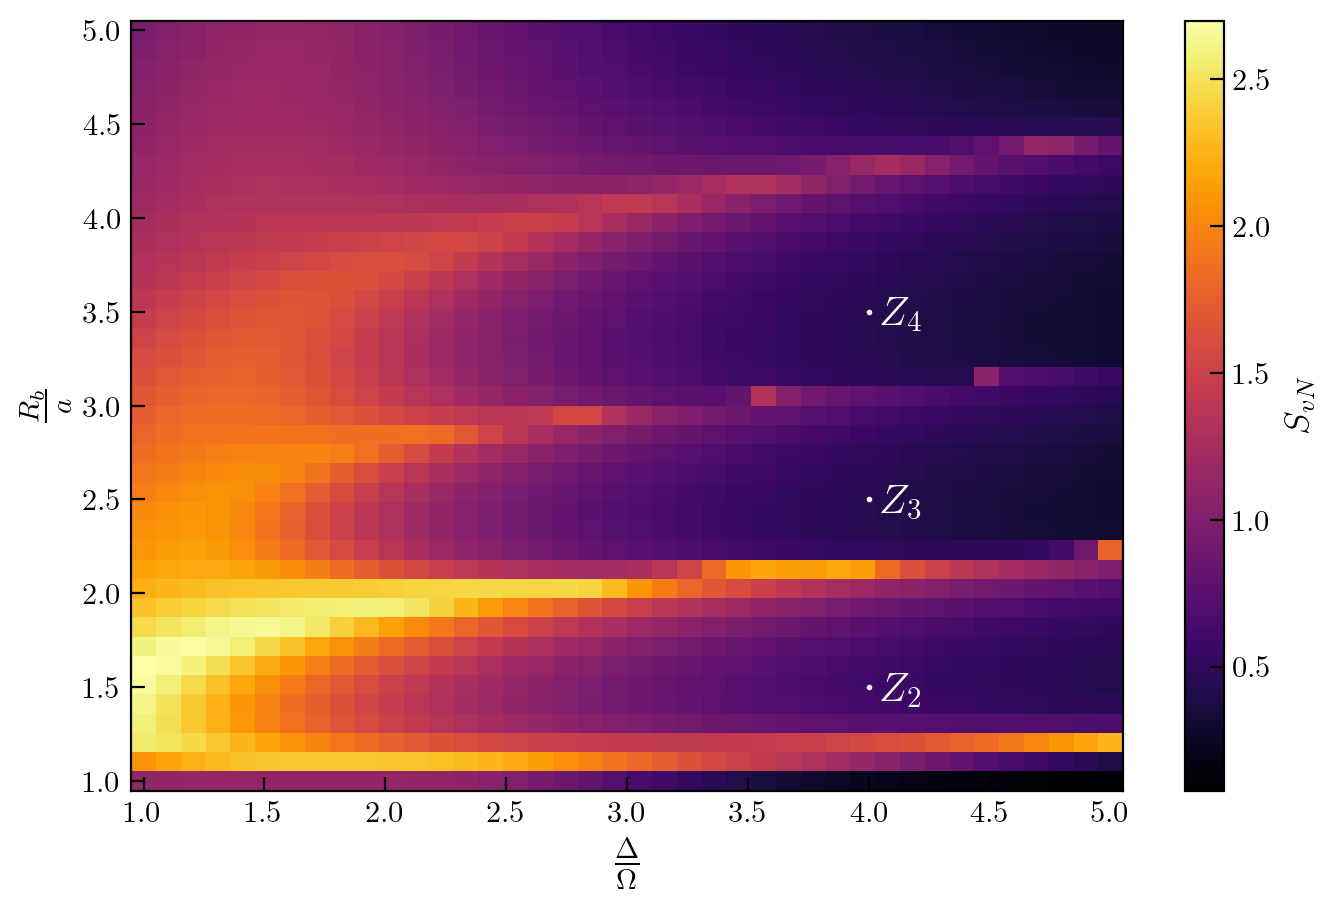

In [122]:
X, Y = np.meshgrid(
    np.linspace(1,5,40),
    np.linspace(1,5,40) # y_max = 4 ?
)

phase = np.load("phase55.npy")

fig, ax = plt.subplots(figsize=(8,5), dpi=200)

c = ax.pcolormesh(X, Y, phase.T, cmap='inferno')
ax.set_xlabel(r'$\frac{\Delta}{\Omega}$', size=15)
ax.set_ylabel(r'$\frac{R_b}{a}$', size=15)

ax.scatter([4, 4, 4],[1.5, 2.5, 3.5], c='white', s=1)
# ax.text(3+.05, 0.5-.1, r'$Z_1$', c='white', size=13)
ax.text(4+.05, 1.5-.07, r'$Z_2$', c='white', size=15)
ax.text(4+.05, 2.5-.07, r'$Z_3$', c='white', size=15)
ax.text(4+.05, 3.5-.07, r'$Z_4$', c='white', size=15)

ax.tick_params(labelsize=11)

cb = fig.colorbar(c, ax=ax)
cb.ax.tick_params(labelsize=11)
cb.set_label(r'$S_{vN}$', size=13)

In [15]:
lat = lattice(13, legs=1, bc='OBC', constraint=False)

KeyboardInterrupt: 

1.7996


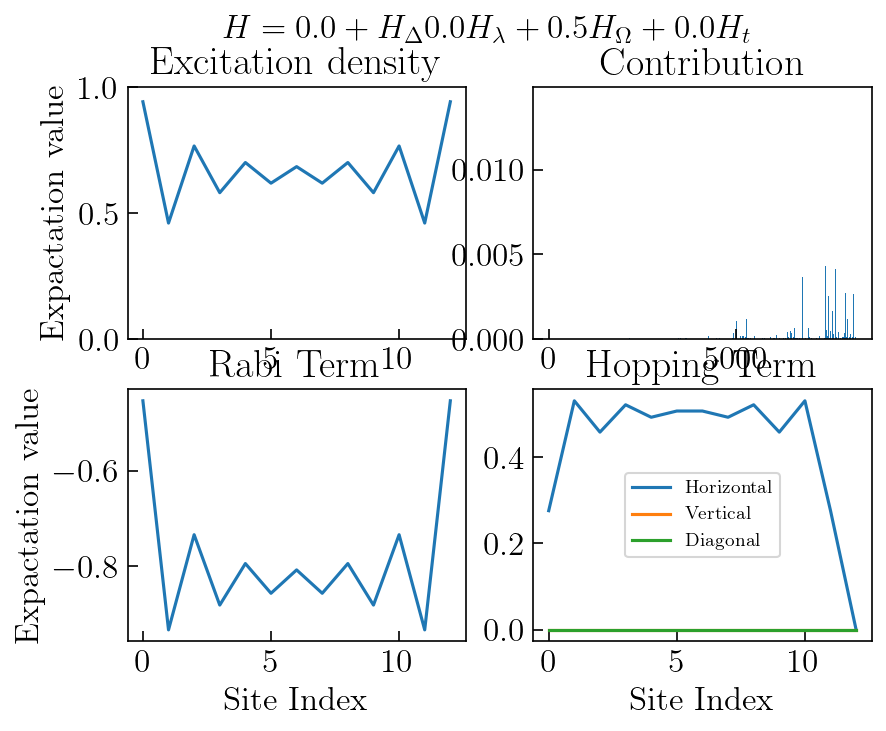

In [20]:
L=13
mat = matrix(lat, num=-3, rabi=1/2, int=1.1**6)
fig = create_plot(lat, mat)
print(S_vn(mat.gs, L,L//2+L%2,L//2))

In [103]:
L=13
lat = lattice(13, legs=1, bc='OBC', constraint=False)
mat = []

int = [1.5,2.5,3.5,4.5]
cols = len(int)

for j in range(4):
    mat.append(matrix(lattice=lat, num=-3, rabi=1/2, int=int[j]**6))

In [106]:
L=13
lat = lattice(L, legs=1, bc='OBC', constraint=False)
mat = []

int = [1.5,2.5,3.5,4.5]

for j in range(4):
    mat.append(matrix(lattice=lat, num=-4, rabi=1/2, int=int[j]**6))

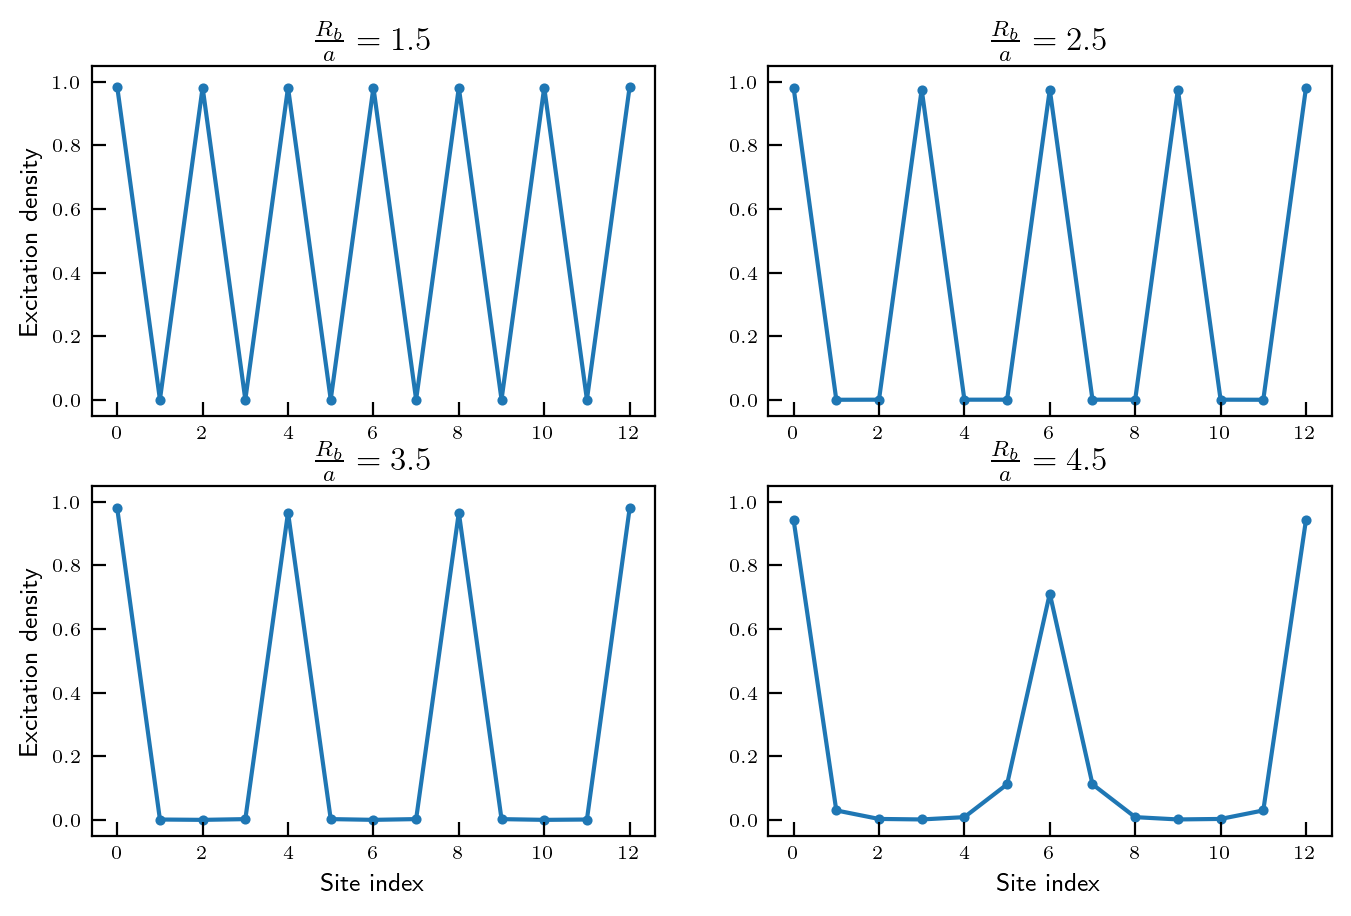

In [107]:
fig, ax = plt.subplots(nrows=2, ncols=2, dpi=200, figsize=(8,5))

for i,j in product([0,1],[0,1]):
    density = [np.sum([mat[2*i+j].gs[k]**2 * mat[2*i+j].basis[k][0,x] for k in range(len(mat[2*i+j].basis))]) for x in range(mat[2*i+j].sites)]
    ax[i,j].plot(density)
    ax[i,j].scatter(range(len(density)), density, s=7)
    
    ax[i,j].set_title(rf'$\frac{{R_b}}{{a}}={int[2*i+j]}$', size=12)
    ax[1,j].set_xlabel('Site index', size=9)
    ax[i,0].set_ylabel('Excitation density', size=9)
    ax[i,j].set_ylim(-0.05, 1.05)

# fig.savefig(fname='z_n.png', dpi=200)

In [108]:
lat1 = lattice(11, legs=1, bc='OBC', constraint=False)
lat2 = lattice(13, legs=1, bc='OBC', constraint=False)

mat = []
mat.append(matrix(lat1, num=-4, rabi=1/2, int=4.5**6))
mat.append(matrix(lat2, num=-4, rabi=1/2, int=5.5**6))

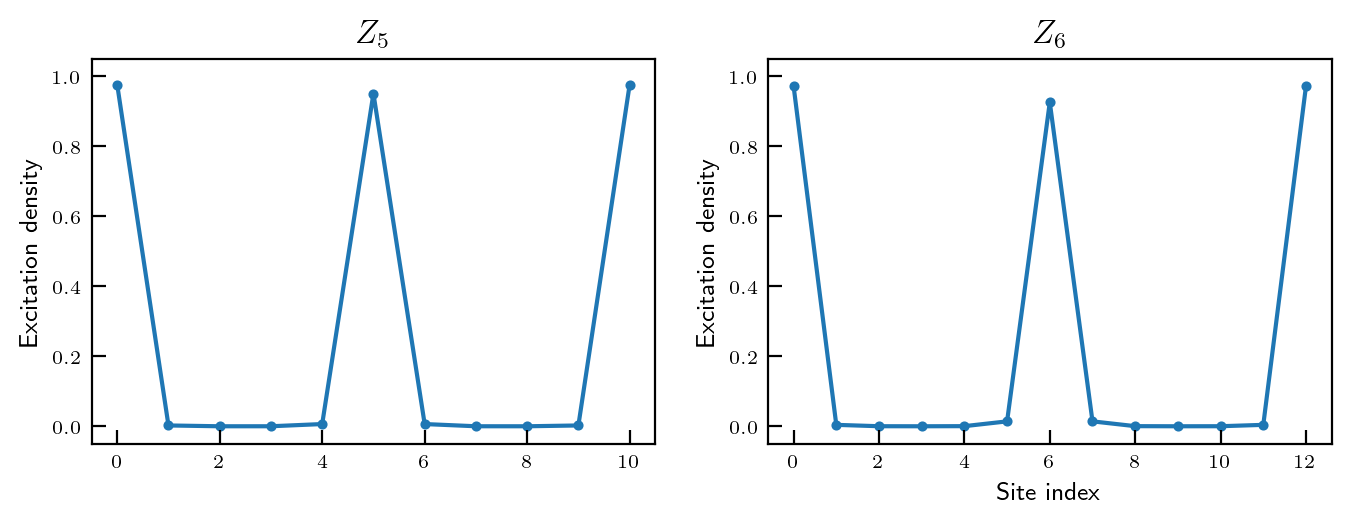

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200, figsize=(8,2.5))

title = [r'$Z_5$', r'$Z_6$']

for i in range(2):
    density = [np.sum([mat[i].gs[k]**2 * mat[i].basis[k][0,x] for k in range(len(mat[i].basis))]) for x in range(mat[i].sites)]
    ax[i].plot(density)
    ax[i].scatter(range(len(density)), density, s=7)
    
    ax[i].set_title(title[i], size=12)
    ax[1].set_xlabel('Site index', size=9)
    ax[i].set_ylabel('Excitation density', size=9)
    ax[i].set_ylim(-0.05, 1.05)

# fig.savefig(fname='low_det_pbc.png')

In [50]:
L=21
lat = lattice(L, legs=1, bc='OBC', constraint=True)
mat = []

num = [-1/2,0,1/2,1]
cols = len(num)

for j in range(cols):
    mat.append(matrix(lattice=lat, num=-num[j], rabi=1/2))

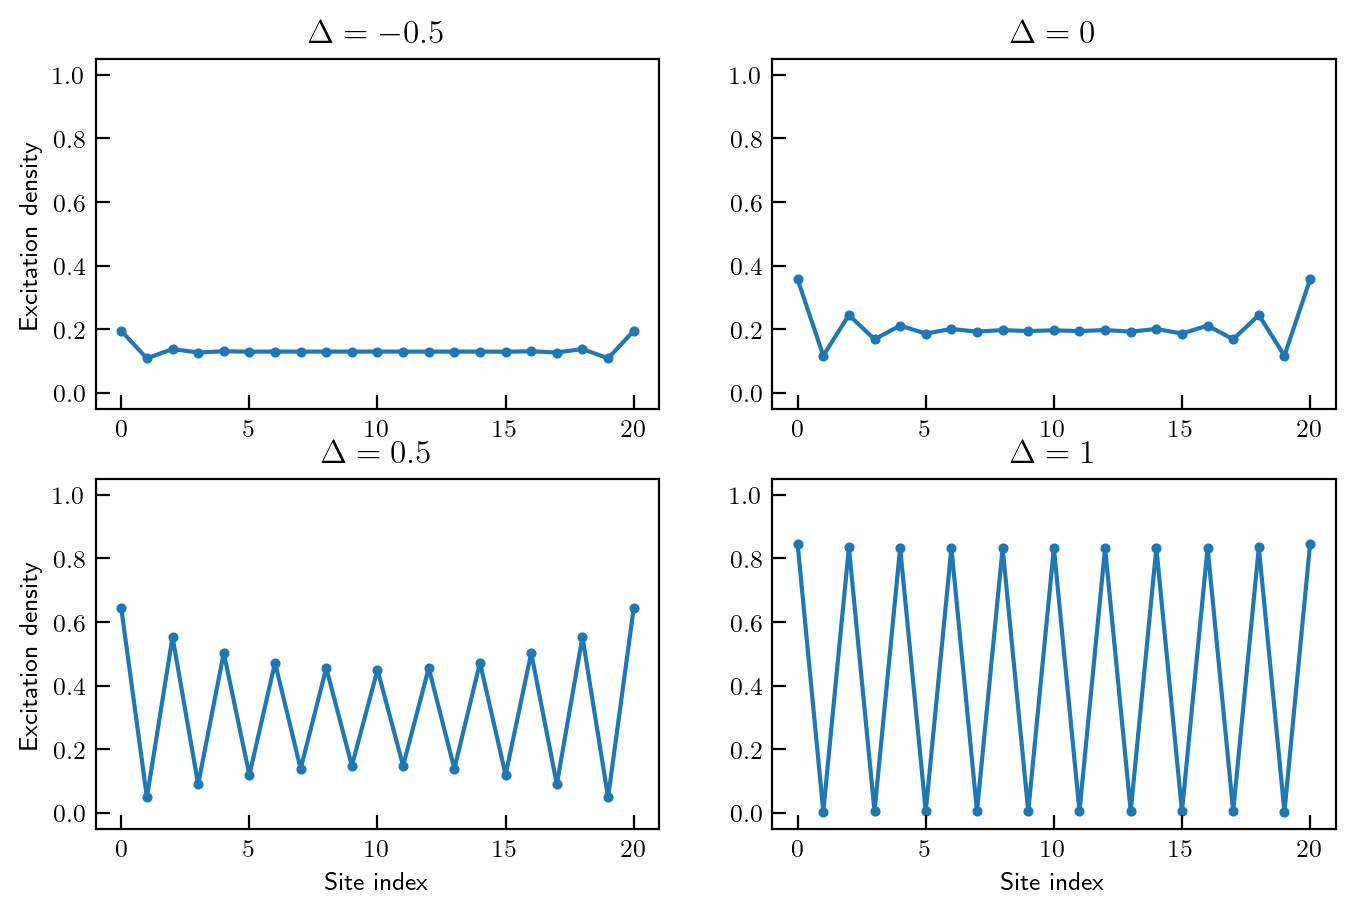

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=2, dpi=200, figsize=(8,5))

for i,j in product([0,1],[0,1]):
    density = [np.sum([mat[2*i+j].gs[k]**2 * mat[2*i+j].basis[k][0,x] for k in range(len(mat[2*i+j].basis))]) for x in range(mat[2*i+j].sites)]
    ax[i,j].plot(density)
    ax[i,j].scatter(range(len(density)), density, s=7)
    
    ax[i,j].set_title(rf'$\Delta={num[2*i+j]}$', size=12)
    ax[1,j].set_xlabel('Site index', size=9)
    ax[i,0].set_ylabel('Excitation density', size=9)
    ax[i,j].set_ylim(-0.05, 1.05)

    # rabi = [mat[j].gs.T @ lat.r_rabi[0,x] @ mat[j].gs for x in range(mat[j].sites)]
    # ax[1,j].plot(rabi)
    # ax[1,j].scatter(range(len(rabi)), rabi, s=7)
    # ax[1,j].set_ylim(-0.55, 0.05)

# ax[1].set_ylim(-0.05, .55)
# ax[2].set_ylim(-0.05, .55)


# ax[0].set_yticks([0,0.1,0.2,0.3,0.4,0.5], labels=[0,0.1,0.2,0.3,0.4,0.5])
# ax[0].set_xticks(np.arange(0, L, int(np.round(L/5))), labels=np.arange(0, L, int(np.round(L/5))))
# ax[1].set_xticks(np.arange(0, L, int(np.round(L/5))), labels=np.arange(0, L, int(np.round(L/5))))
# ax[2].set_xticks(np.arange(0, L, int(np.round(L/5))), labels=np.arange(0, L, int(np.round(L/5))))

# fig.suptitle('Test')


# fig.savefig(fname='z_n.png', dpi=200)

In [61]:
L=21
lat = lattice(L, legs=1, bc='PBC', constraint=True)
mat = []

num = [0,1/2]
cols = len(num)

for j in range(cols):
    mat.append(matrix(lattice=lat, num=-num[j], rabi=1/2))

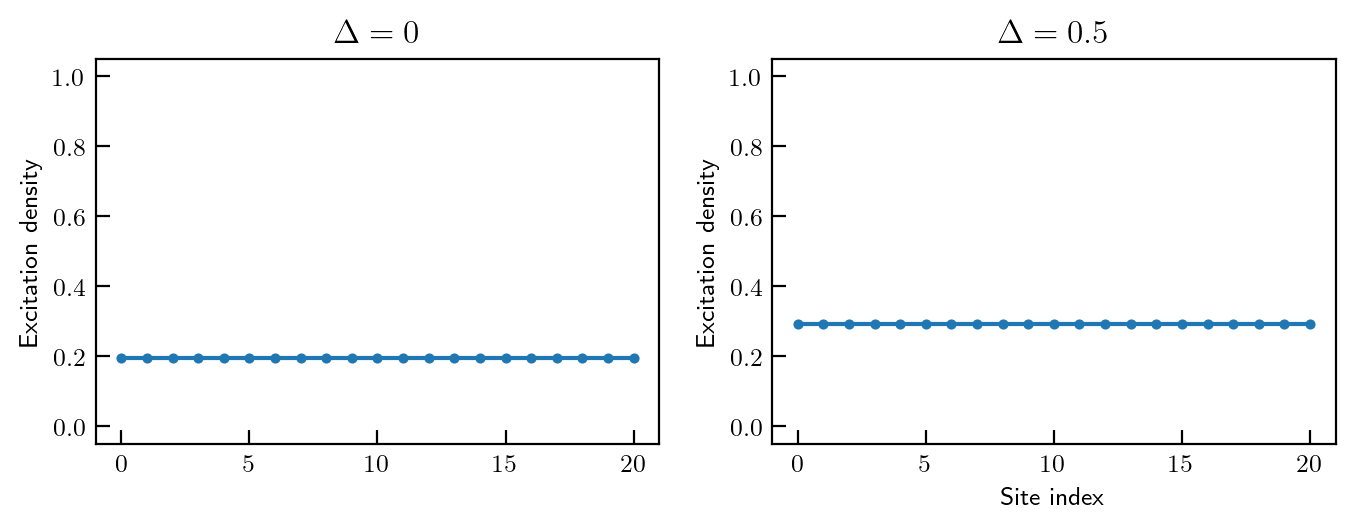

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200, figsize=(8,2.5))

for i in range(2):
    density = [np.sum([mat[i].gs[k]**2 * mat[i].basis[k][0,x] for k in range(len(mat[i].basis))]) for x in range(mat[i].sites)]
    ax[i].plot(density)
    ax[i].scatter(range(len(density)), density, s=7)
    
    ax[i].set_title(rf'$\Delta={num[i]}$', size=12)
    ax[1].set_xlabel('Site index', size=9)
    ax[i].set_ylabel('Excitation density', size=9)
    ax[i].set_ylim(-0.05, 1.05)

# fig.savefig(fname='low_det_pbc.png')

In [57]:
L=21
lat = lattice(L, legs=1, bc='OBC', constraint=True)
mat = []

rabi = [1/2, 1/2, 2, 0]
hop = [0, 1, 1, 1]

for j in range(4):
    mat.append(matrix(lattice=lat, rabi=rabi[j], hop=hop[j]))

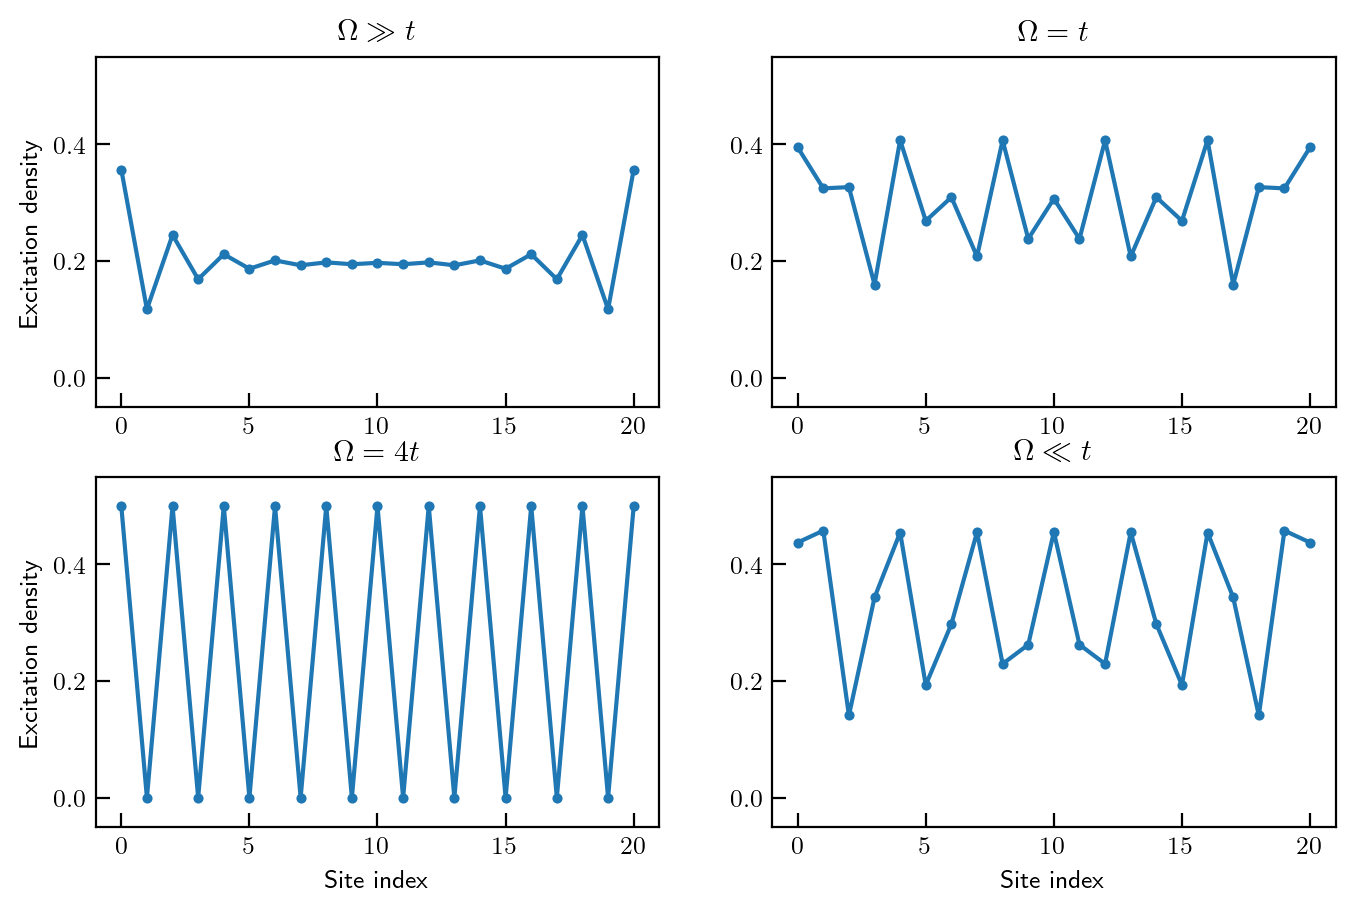

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=2, dpi=200, figsize=(8,5))

title = [r'$\Omega\gg t$', r'$\Omega=t$', r'$\Omega=4t$', r'$\Omega\ll t$']

for i,j in product([0,1],[0,1]):
    density = [np.sum([mat[2*i+j].gs[k]**2 * mat[2*i+j].basis[k][0,x] for k in range(len(mat[2*i+j].basis))]) for x in range(mat[2*i+j].sites)]
    ax[i,j].plot(density)
    ax[i,j].scatter(range(len(density)), density, s=7)
    
    ax[i,j].set_title(title[2*i+j])
    ax[1,j].set_xlabel('Site index', size=9)
    ax[i,0].set_ylabel('Excitation density', size=9)
    ax[i,j].set_ylim(-0.05, .55)

fig.savefig(fname='zigzag.png', dpi=200)

Text(0, 0.5, 'Excitation density')

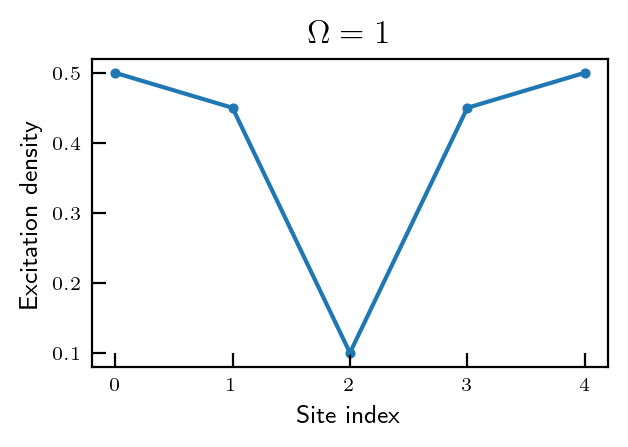

In [17]:
L = 5
lat2 = lattice(L)

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=200, figsize=(10/3, 2))

mat = matrix(lattice=lat2, hop=1/2, int=0)
density = [np.sum([mat.gs[k]**2 * mat.basis[k][0,x] for k in range(len(mat.basis))]) for x in range(mat.sites)]
ax.plot(np.array(density))
ax.scatter(range(len(density)), np.array(density), s=7)

ax.set_title(r'$\Omega=1$', size=12)
# ax[1].set_title(r'$\Omega = 4t$', size=12)
# ax[2].set_title(r'$\Omega \ll t$', size=12)
# ax.set_ylim(-0.05, .55)
# ax[1].set_ylim(-0.05, .55)
# ax[2].set_ylim(-0.05, .55)

ax.set_xlabel('Site index', size=9)
# ax[1].set_xlabel('Site index', size=9)
# ax[2].set_xlabel('Site index', size=9)

# ax.set_xticks(np.arange(0, L, int(np.round(L/5))), labels=np.arange(0, L, int(np.round(L/5))))

# fig.suptitle('Test')
ax.set_ylabel('Excitation density', size=9)

Text(0, 0.5, 'Excitation density')

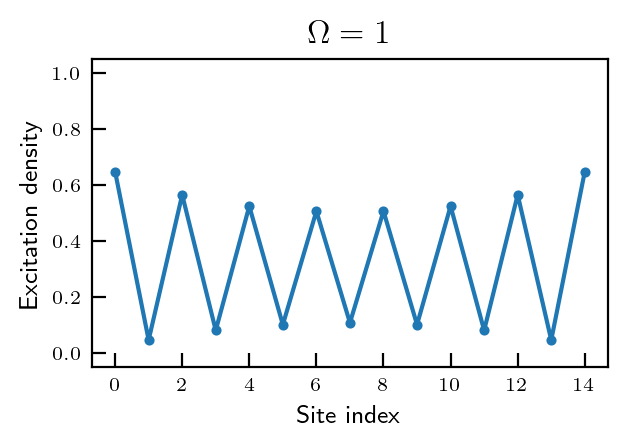

In [22]:
lat = lattice(15)

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=200, figsize=(10/3, 2))

mat = matrix(lattice=lat, num=-1/2,rabi=1/2)
density = [np.sum([mat.gs[k]**2 * mat.basis[k][0,x] for k in range(len(mat.basis))]) for x in range(mat.sites)]
ax.plot(density)
ax.scatter(range(len(density)), density, s=7)

ax.set_title(r'$\Omega=1$', size=12)
ax.set_ylim(-0.05, 1.05)

ax.set_xlabel('Site index', size=9)
ax.set_ylabel('Excitation density', size=9)